In [1]:
import numpy as np
from torch_geometric.data import Data
import json
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import os
from core.datasetclass import HydrogelNonLinearDataset
from core.model_graphnet_nl import EncodeProcessDecode
import numpy as np
from tqdm import tqdm
from core.utils import * 
import h5py
import meshio
import time
from run_rollout_nl import rollout
device = "cuda"



In [22]:
data_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/dataset/nl_dataset"
# data_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/testcases/"
# data_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/dataset/linear_extr_testcases"
# output_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/rollout/{test_on}"
# paraview_dir = f"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/rollout/{test_on}"

time_window = 1
model_dir = r"/mnt/c/Users/narun/OneDrive/Desktop/Project/Hydrogel_MGN/Hydrogel_MGN/trained_model/2025-05-30T16h33m36s/model_checkpoint"
dataset = HydrogelNonLinearDataset(data_dir, add_targets= True, split_frames=True, add_noise = False, time_window=time_window)
data = dataset[0]
model = EncodeProcessDecode(node_feature_size = 5,
                            mesh_edge_feature_size = 7,
                            output_size = 3,
                            latent_size = 128,
                            timestep=1e-5,
                            time_window=time_window,
                            device=device,
                            message_passing_steps = 15)
model.to(device)
model.load_model(model_dir)
model.eval()
model = torch.compile(model)
# Training loop
output = rollout(model, data, time_window)

Rollout: 100%|██████████| 248/248 [00:04<00:00, 52.28it/s]


In [23]:
output.keys()

dict_keys(['mesh_pos', 'node_type', 'cells', 'predict_displacement', 'gt_displacement', 'predict_chem_pot', 'gt_chem_pot', 'disp_mse', 'chem_pot_mse'])

In [24]:
output["gt_displacement"]

[tensor([[-4.2570e-21, -4.2570e-21],
         [ 4.6135e-04, -9.7913e-21],
         [ 9.2270e-04, -5.1085e-21],
         ...,
         [ 1.0614e-02,  1.1539e-02],
         [ 1.1076e-02,  1.1540e-02],
         [ 1.1542e-02,  1.1542e-02]], device='cuda:0'),
 tensor([[[-4.2572e-21, -4.2572e-21],
          [ 4.6135e-04, -9.7916e-21],
          [ 9.2270e-04, -5.1087e-21],
          ...,
          [ 1.0618e-02,  1.1544e-02],
          [ 1.1080e-02,  1.1547e-02],
          [ 1.1551e-02,  1.1551e-02]]], device='cuda:0'),
 tensor([[[-4.2573e-21, -4.2573e-21],
          [ 4.6135e-04, -9.7919e-21],
          [ 9.2270e-04, -5.1090e-21],
          ...,
          [ 1.0621e-02,  1.1550e-02],
          [ 1.1085e-02,  1.1554e-02],
          [ 1.1561e-02,  1.1561e-02]]], device='cuda:0'),
 tensor([[[-4.2574e-21, -4.2574e-21],
          [ 4.6135e-04, -9.7923e-21],
          [ 9.2271e-04, -5.1092e-21],
          ...,
          [ 1.0625e-02,  1.1556e-02],
          [ 1.1090e-02,  1.1561e-02],
          [ 1.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_result(
    mesh_pos: np.array,
    node_connectivity: np.array,
    pred_displacement: np.array,
    gt_displacement: np.array,
    pred_chem_pot: np.array,
    gt_chem_pot: np.array,
    desc: str
):
    """
    Plots predicted vs ground truth displacement fields and chemical potential.

    Parameters:
        mesh_pos (np.array): Node positions (N, 2)
        node_connectivity (np.array): Triangular connectivity (M, 3)
        displacement_pred (np.array): Predicted displacement (N, 2)
        displacement_gt (np.array): Ground truth displacement (N, 2)
        chem_potential (np.array): Scalar chemical potential at nodes (N,)
        desc (str): Description title
    """

    # Create triangulation
    triangulation = tri.Triangulation(mesh_pos[:, 0], mesh_pos[:, 1], node_connectivity)

    # Set up subplots: 3 columns for disp_x, disp_y, chem_potential; 3 rows: pred, gt, error
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fields = ['Displacement X (m)', 'Displacement Y (m)', 'Chemical Potential']
    data_pairs = [
        (pred_displacement[:, 0], gt_displacement[:, 0]),
        (pred_displacement[:, 1], gt_displacement[:, 1]),
        (pred_chem_pot[:,0], gt_chem_pot[:,0])  # chem_potential = pred = gt (no comparison)
    ]
    print(pred_displacement[:, 0].shape)
    for col, (pred_field, gt_field) in enumerate(data_pairs):
        # Row 0: Prediction
        im0 = axes[0, col].tripcolor(triangulation, pred_field, shading='flat', cmap='seismic')
        axes[0, col].triplot(triangulation, color='black', linewidth=0.25)
        axes[0, col].set_title(f"{desc} Prediction - {fields[col]}")
        axes[0, col].set_aspect('equal')
        fig.colorbar(im0, ax=axes[0, col], orientation='vertical')

        # Row 1: Ground Truth
        im1 = axes[1, col].tripcolor(triangulation, gt_field, shading='flat', cmap='seismic')
        axes[1, col].triplot(triangulation, color='black', linewidth=0.25)
        axes[1, col].set_title(f"{desc} Ground Truth - {fields[col]}")
        axes[1, col].set_aspect('equal')
        fig.colorbar(im1, ax=axes[1, col], orientation='vertical')

        # Row 2: Absolute Error
        error_field = pred_field - gt_field
        cmap = 'seismic'  # diverging colormap

        # Center color map at 0
        im2 = axes[2, col].tripcolor(triangulation, error_field, shading='flat', cmap=cmap, vmax = np.max(np.abs(error_field)), vmin = -np.max(np.abs(error_field)))
        axes[2, col].triplot(triangulation, color='black', linewidth=0.25)
        axes[2, col].set_title(f"{desc} Error - {fields[col]}")
        axes[2, col].set_aspect('equal')
        fig.colorbar(im2, ax=axes[2, col], orientation='vertical')

    fig.suptitle(f"{desc} - Field Comparisons", fontsize=18)
    plt.tight_layout()
    plt.show()


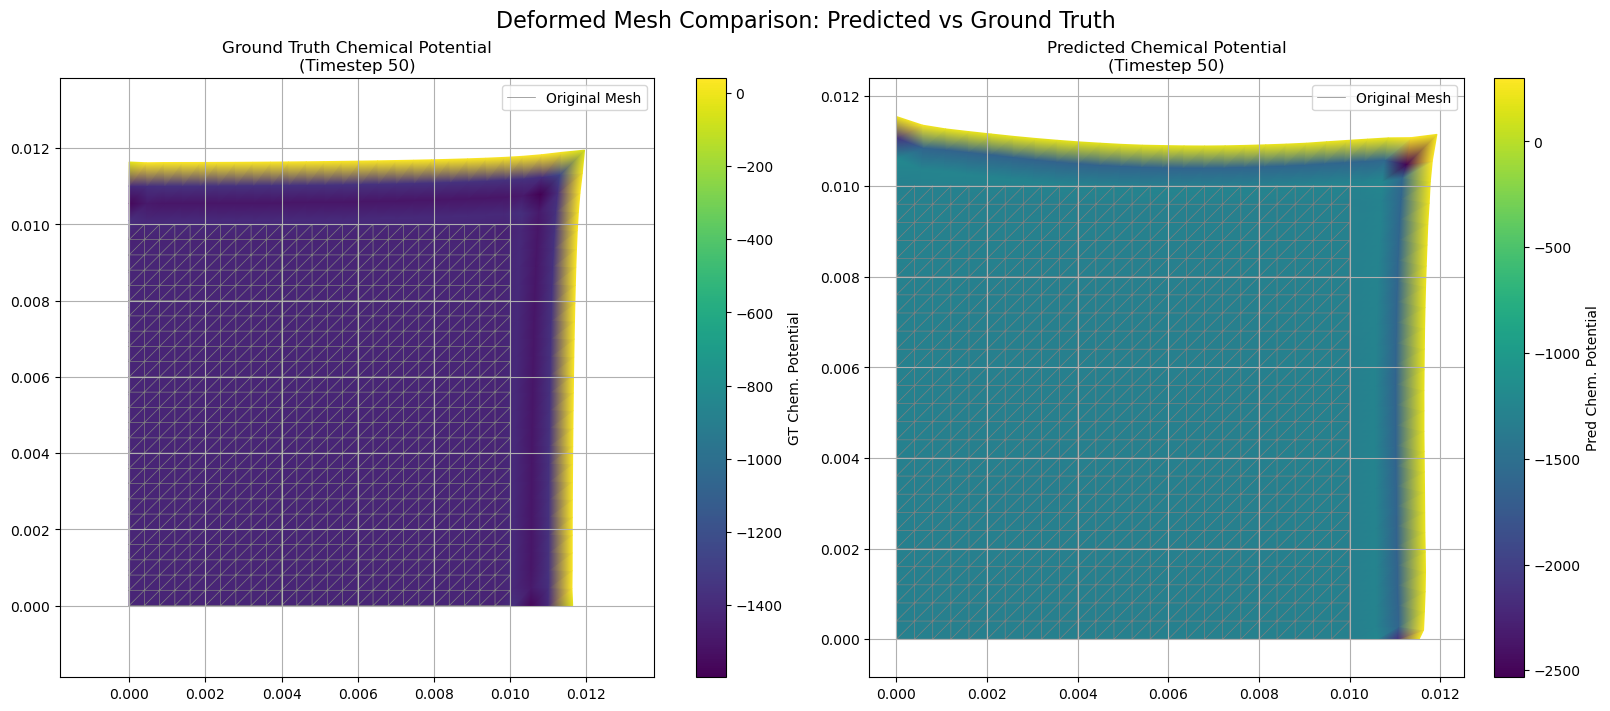

In [26]:
# Setup
timestep = 50
mesh_pos = output["mesh_pos"].detach().cpu().numpy()
cells = output["cells"].detach().cpu().numpy()
pred_displacement = output["predict_displacement"][timestep].squeeze(0).detach().cpu().numpy()
gt_displacement = output["gt_displacement"][timestep].squeeze(0).detach().cpu().numpy()
pred_chem_pot = output["predict_chem_pot"][timestep].squeeze(0).detach().cpu().numpy()
gt_chem_pot = output["gt_chem_pot"][timestep].squeeze(0).detach().cpu().numpy()

# Deformed positions
deformed_nodes_gt = gt_displacement
deformed_nodes_pred = pred_displacement

# Triangulations
triang_gt = tri.Triangulation(deformed_nodes_gt[:, 0], deformed_nodes_gt[:, 1], cells)
triang_pred = tri.Triangulation(deformed_nodes_pred[:, 0], deformed_nodes_pred[:, 1], cells)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

# Ground truth
tpc1 = axs[0].tripcolor(triang_gt, gt_chem_pot.squeeze(), shading='gouraud', cmap='viridis', edgecolors='k', linewidth=0.2)
axs[0].triplot(mesh_pos[:, 0], mesh_pos[:, 1], cells, color='grey', linewidth=0.5, label='Original Mesh')
axs[0].set_title(f'Ground Truth Chemical Potential\n(Timestep {timestep})')
axs[0].axis('equal')
axs[0].grid(True)
axs[0].legend()
fig.colorbar(tpc1, ax=axs[0], label='GT Chem. Potential')

# Prediction
tpc2 = axs[1].tripcolor(triang_pred, pred_chem_pot.squeeze(), shading='gouraud', cmap='viridis', edgecolors='k', linewidth=0.2)
axs[1].triplot(mesh_pos[:, 0], mesh_pos[:, 1], cells, color='grey', linewidth=0.5, label='Original Mesh')
axs[1].set_title(f'Predicted Chemical Potential\n(Timestep {timestep})')
axs[1].axis('equal')
axs[1].grid(True)
axs[1].legend()
fig.colorbar(tpc2, ax=axs[1], label='Pred Chem. Potential')

plt.suptitle("Deformed Mesh Comparison: Predicted vs Ground Truth", fontsize=16)
plt.show()

In [32]:
pred_chem_pot.squeeze()

array([[-4.2592507e-21, -4.2592507e-21],
       [ 4.6137517e-04, -9.7975626e-21],
       [ 9.2273642e-04, -5.1126511e-21],
       ...,
       [ 1.0678755e-02,  1.1629542e-02],
       [ 1.1158225e-02,  1.1652711e-02],
       [ 1.1694170e-02,  1.1694170e-02]], shape=(676, 2), dtype=float32)

In [25]:
output["predict_displacement"][25]

tensor([[[1.9749e-04, 9.8347e-05],
         [6.5174e-04, 8.8456e-05],
         [1.1147e-03, 8.3435e-05],
         ...,
         [1.0854e-02, 1.1623e-02],
         [1.1359e-02, 1.1663e-02],
         [1.1940e-02, 1.1726e-02]]], device='cuda:0')